In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd

In [2]:
# Constants
NSHARDS = 10
RESULTS_DIR = '/tmp/mwe'
LOCALDIR = '/tmp'

MODELS = ['GCN_AttributeMask', 'GCN_', 'GraphSAGE_', 'GraphSAGE_AttributeMask', 
          'GCN_CorruptedEmbeddingsReconstruction', 'GCN_CorruptedFeaturesReconstruction', 'GCN_AutoEncoding',
         'GCN_GAE','GCN_VGAE','GCN_ARGA','GCN_ARGVA', 'SuperGAT_SuperGATSSL', 'GCN_DenoisingLinkReconstruction',
         'GCN_EdgeMask', 'GCN_GRACE', 'GCN_GCA', 'GCN_BGRL', 'GCN_SelfGNNSplit', 'GCN_SelfGNNPPR', 'GCN_SelfGNNLDP', 
          'GCN_SelfGNNStandard', 'GCN_GBT']

METRIC = 'test_rocauc_ovr'

In [3]:
dfs = []
for shard_idx in range(NSHARDS):
  filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
  print(filename)

  with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
    lines = f.readlines()
    records = map(json.loads, lines)
    dfs.append(pd.DataFrame.from_records(records))

# Construct df and remove nans
results_df = pd.concat(dfs)
results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
results_df.dropna(axis=0, inplace=True)
del dfs

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [4]:
results_df.columns

Index(['nvertex', 'avg_degree', 'feature_center_distance', 'feature_dim',
       'edge_center_distance', 'edge_feature_dim', 'p_to_q_ratio',
       'num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'generator_name', 'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'approximate_diameter', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'edge_homogeneity', 'avg_in_feature_angular_distance',
       'avg_out_feature_angular_distance', 'feature_angular_snr',
       'pareto_exponent', 'avg_degree_est', 'community_size_simpsons',
       'p_to_q_ratio_est', 'p_to_q_ratio__est_dc', 'skipped', 'sample_id',
       'GCN_GBT_val_accuracy', 'GCN_GBT_val_f1_micro', 'GCN_GBT_val_f1_macro',
       'GCN_GBT_val_rocauc_ovr', 'GCN_GBT_val_rocauc_ovo',
       'GCN_GBT_val_logloss', 'GCN_GBT_test_accuracy', 'GCN_GBT_test_f1_micro',
       'GCN_GBT_test_f1

In [5]:
results_df['GCN_']

KeyError: 'GCN_'

In [6]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df,
                            models=MODELS,
                            reverse_x=False, ci=99):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s_%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  # Make the plot
  fig = plt.figure(figsize=(10, 10))

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", ci=ci)
  plt.title('%s vs %s' % (metric, param))
  plt.show()

In [7]:
results_df

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,GCN__test_rocauc_ovo,GCN__test_logloss,GCN__train_epochs,GCN__train_lr,GCN__train_lambda,GCN__model_in_channels,GCN__model_hidden_channels,GCN__model_num_layers,GCN__model_dropout,GCN__model_out_channels
0,465,12.292473,3.323765,16,2.0,2,23.202039,4,0.484742,3.0,...,0.749553,1.357595,100,0.0010,0.010,16,4,2,0.3,4
0,250,12.216867,3.339854,16,2.0,2,46.854832,4,0.871147,3.0,...,0.945788,1.386294,100,0.0010,0.100,16,4,2,0.3,4
0,316,9.620254,2.739994,16,2.0,2,49.093222,4,0.075767,3.0,...,0.500000,16.397133,100,0.0001,0.010,16,4,4,0.8,4
0,390,12.113111,2.471310,16,2.0,2,46.208893,4,0.716341,3.0,...,0.500000,1.536455,100,0.0001,1.000,16,16,4,0.3,4
0,379,10.360743,1.512422,16,2.0,2,22.941535,4,0.697703,3.0,...,0.954622,1.357669,100,0.0100,0.001,16,8,1,0.8,4
0,271,9.158671,1.361308,16,2.0,2,25.058541,4,0.729844,3.0,...,0.994565,0.509512,100,0.0100,10.000,16,8,1,0.3,4
0,290,10.710345,4.479430,16,2.0,2,11.327196,4,0.069362,3.0,...,0.500000,17.817350,100,0.0001,10.000,16,16,2,0.0,4
0,333,9.969970,2.268579,16,2.0,2,15.488364,4,0.231268,3.0,...,0.803056,8.113336,100,0.0010,0.100,16,16,4,0.0,4
0,223,8.627803,3.457526,16,2.0,2,36.638077,4,0.430676,3.0,...,0.993830,0.135288,100,0.0010,0.010,16,16,1,0.3,4
0,457,9.199124,4.541593,16,2.0,2,13.482356,4,0.032254,3.0,...,0.866870,2.167829,100,0.0100,0.100,16,4,3,0.3,4


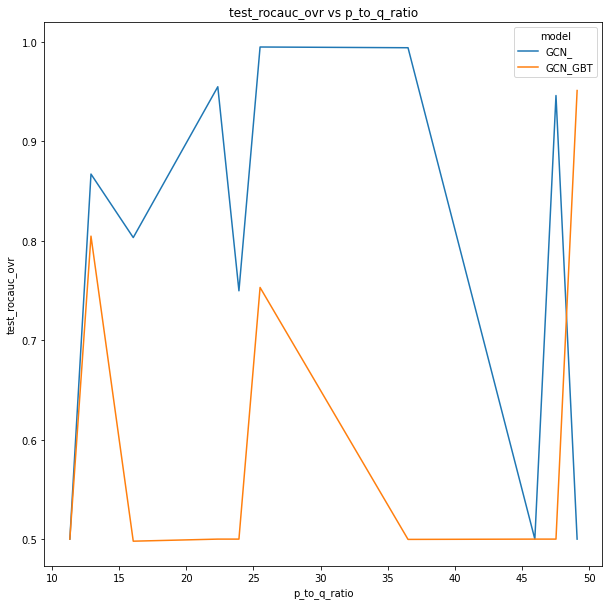

In [8]:
plot_response_surface1d('p_to_q_ratio', METRIC, results_df)